In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv("Dataset/insurance.csv")

In [3]:
# Display data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
# Analyze potential missing values / NaN (Result: We do not have any missing values)
df[df.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


In [5]:
# Label encoded: Converted categorical labels into integer codes
cols = ["sex", "smoker", "region"]
for col in cols:
    df[col] = df[col].astype("category").cat.codes

In [6]:
corr = df.select_dtypes(include=['number']).corr()["charges"]
corr

age         0.299008
sex         0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
region     -0.006208
charges     1.000000
Name: charges, dtype: float64

Lets take a look at the bar plot for a better visual understanding.

Text(0, 0.5, 'Correlation level')

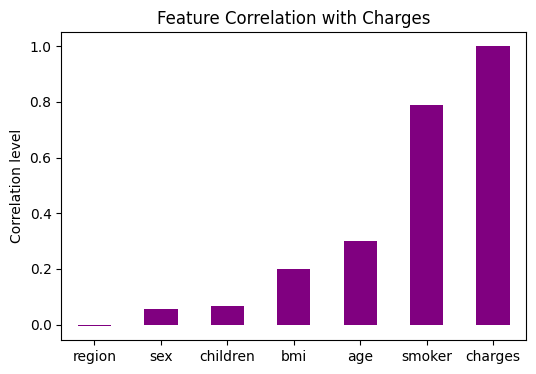

In [7]:
ax = corr.sort_values().plot.bar(figsize=(6,4), color="purple")

ax.tick_params(axis="x", labelrotation=0)
ax.set_title("Feature Correlation with Charges")
ax.set_ylabel("Correlation level")

Text(0.5, 1.0, 'Distribution of Non-Smokers')

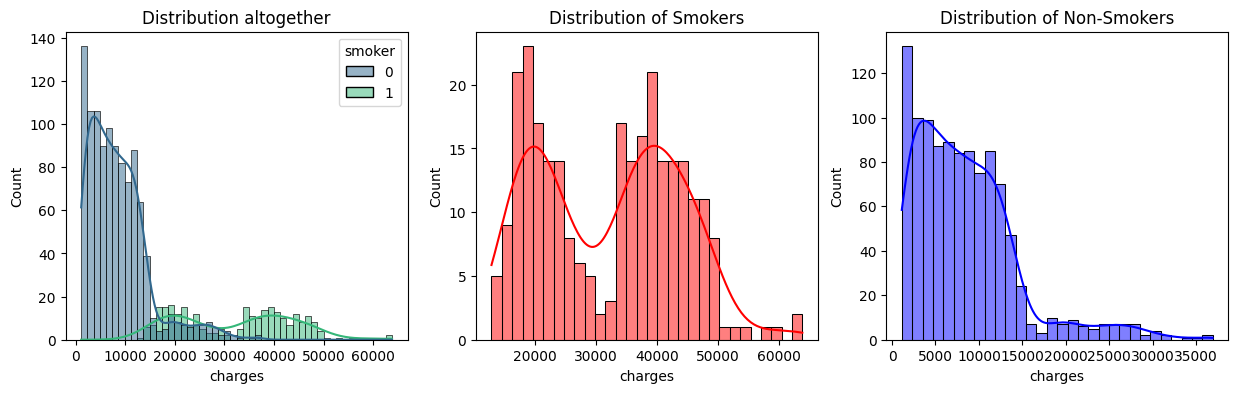

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data=df, x="charges", hue="smoker", kde=True, bins=50, palette="viridis", ax=axes[0])
axes[0].set_title("Distribution altogether")

sns.histplot(data=df[df["smoker"] == 1], x="charges", bins=30, color="red", kde=True, ax=axes[1])
axes[1].set_title("Distribution of Smokers")
sns.histplot(data=df[df["smoker"] == 0], x="charges", bins=30, color="blue", kde=True, ax=axes[2])
axes[2].set_title("Distribution of Non-Smokers")

Text(0.5, 1.0, 'Smoker vs Non-Smoker')

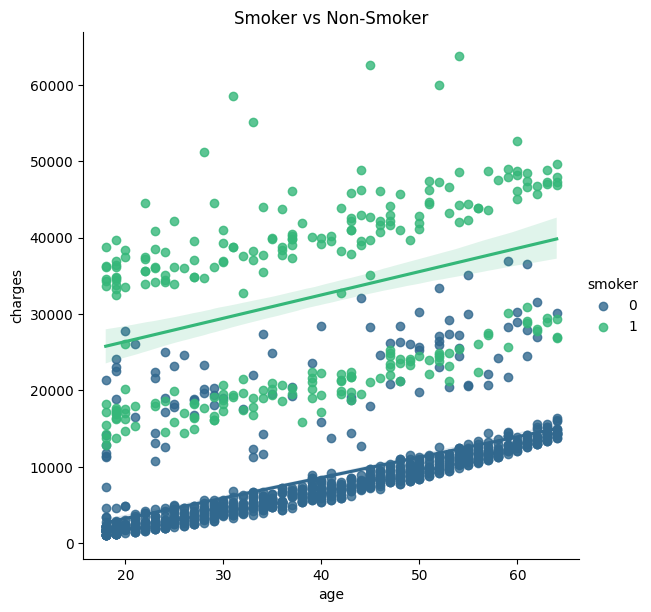

In [9]:
sns.lmplot(x="age", y="charges", hue="smoker", palette="viridis", height=6,data=df)
plt.title("Smoker vs Non-Smoker")

In [10]:
# Check mean
df.groupby("smoker")["charges"].mean()

smoker
0     8434.268298
1    32050.231832
Name: charges, dtype: float64

There is a high correlation between smoking status and charges, demonstrating that smokers tend to spend more on treatments.

# Linear Regression to predict Insurance Cost

In [11]:
# Prepare Data 
X = df.drop(columns="charges")
y = df["charges"]    

In [ ]:
poly = PolynomialFeatures()
X = poly.fit_transform(X)

In [12]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=432)

In [13]:
model = LinearRegression()
# Train model by using training data to learn best intercept and slope
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

We have used the training data to produce estimates to predict y based on x values:
$$
\hat{y}_i = \beta_0 + \beta_1 x_i
$$$$
$$

In [14]:
# Obtain the R^2 value
r2 = r2_score(y_test, y_pred)
print(r2)

0.7583723459118734


A decent score from the predicted values to the real values. Let's now optimize.